#### Imports

In [2887]:
import datetime
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LinearRegression

## Global Constants

In [1]:
DATA_FILENAME = "data.json"

## Helper Functions

In [2829]:
def extract_relevant_data(full_zillow_data):
    """
    Argument: `full_zillow_data` is a JSON dictionary from the Zillow data of a sold house.
    """
    house_details = full_zillow_data["data"]["property"]
    relevant_data = {}
    relevant_data["id"] = int(house_details["zpid"])
    relevant_data["price"] = float(house_details["lastSoldPrice"])
    relevant_data["address"] = house_details["abbreviatedAddress"]
    relevant_data["location"] = house_details["formattedChip"]["location"][1]["fullValue"]
    relevant_data["beds"] = float(house_details["bedrooms"])
    relevant_data["baths"] = float(house_details["bathrooms"])
    relevant_data["acres"] = float(house_details["lotAreaValue"])
    if house_details["lotAreaUnits"] == "Square Feet":
        # Convert sqft to acres if needed
        relevant_data["acres"] /= 43560.  
    relevant_data["sqft"] = int(house_details["livingAreaValue"])
    relevant_data["year"] = int(house_details["yearBuilt"])
    relevant_data["lat"] = float(house_details['latitude'])
    relevant_data["lon"] = float(house_details['longitude'])
    relevant_data["realtor"] = house_details["brokerageName"]
    relevant_data["date_sold"] = int(house_details["dateSold"] / 1000)
    
    return relevant_data

def add_entry(json_string, ids):
    """
    Argument: `json_string` should be a non-pretty-printed raw JSON string copied from the
              Network > Response section of the web-browser's inspection window. It could be
              named 'async-create-page-state' or '?extensions=%7B...'.
    """
    full_house_data = json.loads(json_string, strict=False)  # crashes when strict=True (default)
    relevant_data = extract_relevant_data(full_house_data)

    # If the id is a duplicate, don't write it to the file
    if relevant_data["id"] in ids:
        print("id %d is a duplicate" % (relevant_data["id"]))
        return
    f = open(DATA_FILENAME, 'a')
    f.write(json.dumps(relevant_data) + "\n")
    f.close()

def load_present_ids():
    ids = set()
    f = open(DATA_FILENAME, 'r')
    for line in f:
        house_data = json.loads(line)
        ids.add(house_data["id"])
    f.close()
    return ids

def choose_city(location):
    """
    Choose which city this house is close to (Syracuse, Cortland, or Rochester)
    """
    city_name, _ = location.split(',')
    if city_name in ["Cortland", "Homer", "Tully"]:
        return "Cortland"
    elif city_name in ["Syracuse", "Liverpool", "Jamesville", "Dewitt", "Manlius", "Fayetteville", "Minoa", "East Syracuse",\
                 "North Syracuse", "Clay", "Cicero", "Brewerton", "Camillus", "Baldwinsville", "Warners", "Solvay"]:
        return "Syracuse"
    elif city_name in ["Fairport", "Pittsford", "Penfield", "Victor", "Rochester", "Webster"]:
        return "Rochester"
    else:
        raise ValueError("Unknown city %s" % location)

def timestamp_to_year(timestamp):
    """
    Convert the timestamp (in seconds since epoch) to year
    """
    date = datetime.datetime.fromtimestamp(timestamp)
    return date.year

# Add a New Entry Here

In [2818]:
ids = load_present_ids()
# Replace the contents of raw_json.txt
f = open("raw_json.txt", 'r', encoding="utf8")
raw_json = f.read()
f.close()

# Uncomment this code to the relevant json
#js = json.loads(raw_json)["data"]["property"]
#for key in js:
#    if not "Photo" in key and not "View" in key and not "Map" in key and not "Json" in key and not "nearby" in key and not "Valuation" in key:
#        print(key, js[key])

add_entry(raw_json, ids)

id 98684292 is a duplicate


## Inspect the Data

In [2819]:
f = open(DATA_FILENAME, 'r')
all_data = {}
for line in f:
    house_data = json.loads(line)
    for key in house_data:
        if key != "date_sold":
            value = house_data[key]
        else:
            value = datetime.datetime.fromtimestamp(house_data[key])
        try:
            all_data[key].append(house_data[key])
        except KeyError:
            all_data[key] = [house_data[key]]
df = pd.DataFrame.from_dict(all_data)
print("You have data for %d houses" % (len(df)))
print("First 10")
display(df.head(10))
print("Most recent 10")
display(df.tail(10))

You have data for 2358 houses
First 10


,id,price,address,location,beds,baths,sqft,year,lat,lon,realtor,acres,date_sold
0,31765002,280000.0,4202 Henneberry Rd,"Manlius, NY 13104",3.0,2.0,1616,1977,42.975567,-76.002500,Howard Hanna Real Estate,1.2400,1694131200
1,31728477,201000.0,4515 Apulia Rd,"Jamesville, NY 13078",4.0,3.0,2100,1971,42.990322,-76.072260,Bell Home Team,0.5700,1692835200
2,61998985,400000.0,8195 Trellis Brook Ln,"Liverpool, NY 13090",4.0,3.0,2552,2003,43.169643,-76.210380,NextHome CNY Realty,0.2290,1662595200
3,60045157,330900.0,3629 Redhead Ter,"Liverpool, NY 13090",3.0,4.0,1704,2001,43.179996,-76.248474,"Your Home CNY Realty, LLC",0.2092,1656028800
4,31709619,225000.0,4211 Mill Run Rd,"Liverpool, NY 13090",3.0,2.0,1568,1976,43.160206,-76.222730,Hunt Real Estate ERA,0.1800,1696377600
5,31709342,302000.0,8183 Capricorn Dr,"Liverpool, NY 13090",3.0,3.0,1540,1987,43.166700,-76.237040,Syracuse Realty Group,0.2095,1695945600
6,31709639,255000.0,8068 Turtle Cove Rd,"Liverpool, NY 13090",4.0,2.0,1828,1977,43.160100,-76.224560,Century 21 Leah's Signature,0.2545,1695859200
7,31708059,263000.0,4080 Sweet Gum Ln,"Liverpool, NY 13090",3.0,2.0,1506,1984,43.181450,-76.231735,Howard Hanna Real Estate,0.1829,1695772800
8,31710390,360000.0,8211 Penelope Ln,"Liverpool, NY 13090",4.0,3.0,2392,1992,43.166930,-76.215225,"Coldwell Banker Prime Prop,Inc",0.2905,1695081600
9,31712938,210000.0,8009 Princess Path,"Liverpool, NY 13090",3.0,3.0,1682,1968,43.158070,-76.221664,"Coldwell Banker Prime Prop,Inc",0.2009,1695081600


Most recent 10


,id,price,address,location,beds,baths,sqft,year,lat,lon,realtor,acres,date_sold
2348,31900239,226000.0,47 Lynaugh Rd,"Victor, NY 14564",3.0,2.0,1238,1962,42.986300,-77.39707,Tru Agent Real Estate,0.24,1694649600
2349,31900253,230000.0,19 Lynaugh Rd,"Victor, NY 14564",4.0,2.0,1878,1963,42.983330,-77.39792,RE/MAX 1st Commercial,0.34,1621209600
2350,31900268,200000.0,48 Kent Dr,"Victor, NY 14564",4.0,2.0,1475,1962,42.983192,-77.39999,Howard Hanna,0.24,1690502400
2351,31900282,214501.0,22 Somerset Ln,"Victor, NY 14564",4.0,3.0,2311,1962,42.985900,-77.39772,"NORCHAR, LLC",0.24,1651190400
2352,31900440,230000.0,19 Kent Dr,"Victor, NY 14564",3.0,2.0,1850,1970,42.981920,-77.39913,RE/MAX Realty Group,0.28,1666224000
2353,31902151,330000.0,6724 State Route 96,"Victor, NY 14564",3.0,3.0,1982,1987,42.980682,-77.39589,Hunt Real Estate ERA/Columbus,1.87,1664323200
2354,61955616,452000.0,6683 Camden Hill Dr,"Victor, NY 14564",4.0,3.0,2319,2003,42.982600,-77.39389,Tru Agent Real Estate,0.40,1631836800
2355,83950394,471500.0,6657 Saint Johns Pkwy,"Victor, NY 14564",3.0,3.0,3300,2007,42.981823,-77.38970,Howard Hanna,0.70,1634515200
2356,98673414,364900.0,1098 Trevor Run,"Victor, NY 14564",3.0,3.0,2317,2009,42.983080,-77.39224,McAlees Realty,0.50,1608249600
2357,98684292,462600.0,1087 Trevor Run,"Victor, NY 14564",4.0,3.0,3131,2009,42.983350,-77.39083,Howard Hanna,0.40,1627084800


## Add Calculated Columns

In [2833]:
# Calculate the price per square foot
df[["$ per sqft"]] = df["price"] / df["sqft"]

# Calculate the age of the house when sold (in years)
df[["year_sold"]] = [timestamp_to_year(timestamp) for timestamp in df["date_sold"]]
df[["age"]] = df["year_sold"] - df["year"]

# Calculate the price per (square foot + year built)
df[["$ per sqft year"]] = df["price"] / (df["sqft"] + df["year"])

# Categorize each house by which major city it belongs to
df[["city"]] = [choose_city(location) for location in df["location"]]
syr_df = df[df['city'] == "Syracuse"]
cort_df = df[df['city'] == "Cortland"]
roc_df = df[df['city'] == "Rochester"]
print("There are %d houses in the Syracuse area" % len(syr_df))
print("There are %d houses in the Cortland area" % len(cort_df))
print("There are %d houses in the Rochester area" % len(roc_df))

There are 1131 houses in the Syracuse area
There are 125 houses in the Cortland area
There are 1102 houses in the Rochester area


# Analyze the Data

### Basic plot of price per square foot vs date sold

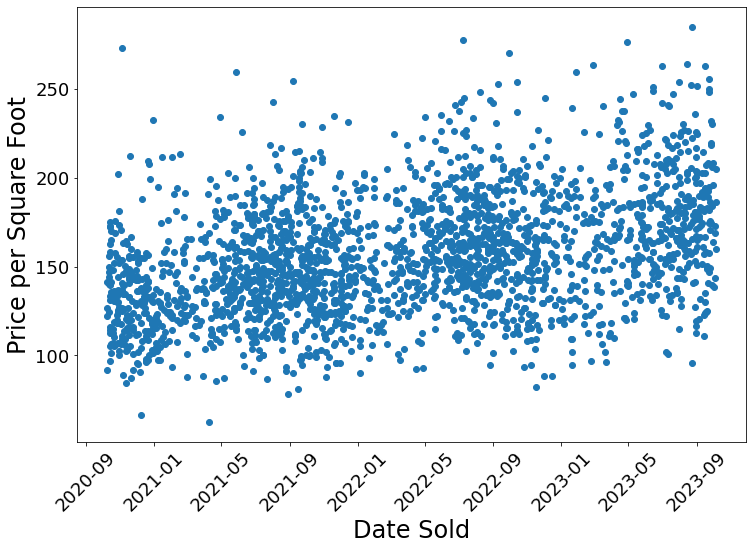

In [2821]:
prices = df.loc[:,"price"]
sqfts = df.loc[:,"sqft"]
dates = [datetime.datetime.fromtimestamp(x) for x in df.loc[:,"date_sold"]]
price_per_sqfts = prices / sqfts

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.plot(dates, price_per_sqfts, 'o')
ax.format_xdata = mdates.DateFormatter('%D:%M:%Y')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel("Date Sold", fontsize=24)
ax.set_ylabel("Price per Square Foot", fontsize=24)
plt.show()

### Basic Scatterplot Separated by City

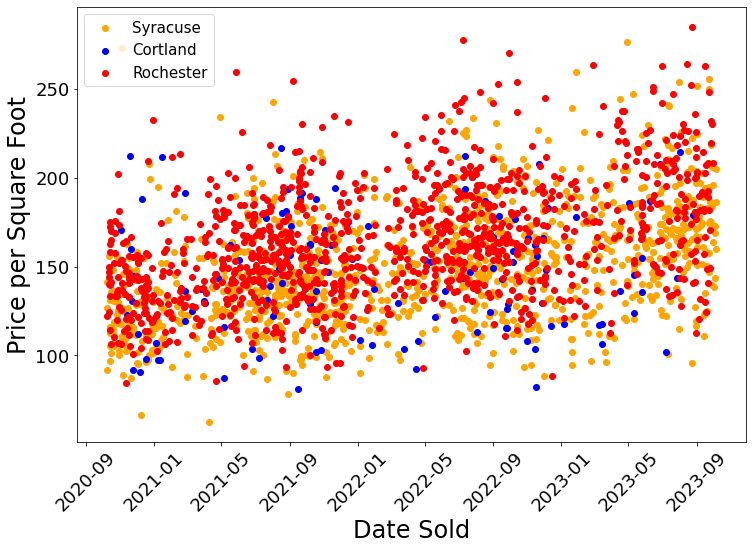

In [2822]:
syr_dates = [datetime.datetime.fromtimestamp(x) for x in syr_df.loc[:,"date_sold"]]
cort_dates = [datetime.datetime.fromtimestamp(x) for x in cort_df.loc[:,"date_sold"]]
roc_dates = [datetime.datetime.fromtimestamp(x) for x in roc_df.loc[:,"date_sold"]]

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.scatter(syr_dates, syr_df['$ per sqft'], color='orange', label="Syracuse")
ax.scatter(cort_dates, cort_df['$ per sqft'], color='blue', label="Cortland")
ax.scatter(roc_dates, roc_df['$ per sqft'], color='red', label="Rochester")
ax.format_xdata = mdates.DateFormatter('%D:%M:%Y')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
ax.set_xlabel("Date Sold", fontsize=24)
ax.set_ylabel("Price per Square Foot", fontsize=24)
plt.show()

### Linear Regression of Price per Square Foot

The slope is $15.243672 per sqft per year
Correlation coefficient: 0.156484


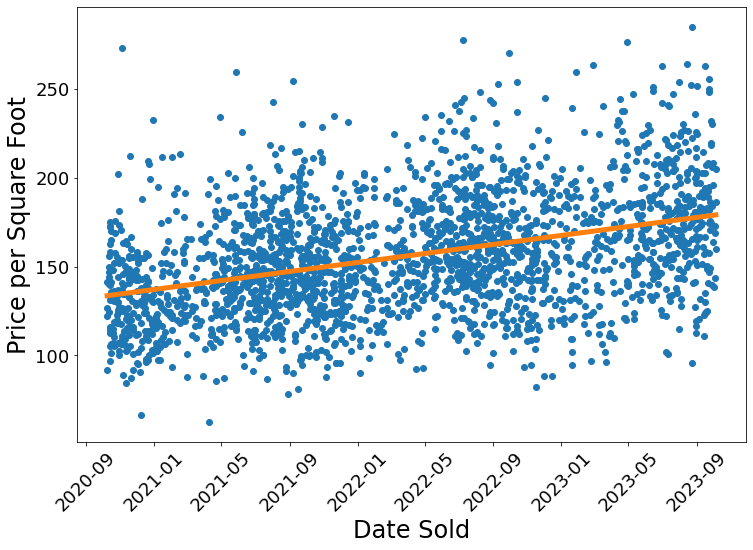

In [2869]:
# Perform the linear regression
X = np.array(df["date_sold"]).reshape(-1, 1)
Y = df["$ per sqft"]
reg = LinearRegression().fit(X, Y)
print("The slope is $%f per sqft per year" % (reg.coef_ * 60 * 60 * 24 * 365.25))
print("Correlation coefficient: %f" % (reg.score(X, Y)))

# Same as above, scatterplot
prices = df.loc[:,"price"]
sqfts = df.loc[:,"sqft"]
dates = [datetime.datetime.fromtimestamp(x) for x in df.loc[:,"date_sold"]]
price_per_sqfts = prices / sqfts
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.plot(dates, price_per_sqfts, 'o')
ax.format_xdata = mdates.DateFormatter('%D:%M:%Y')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel("Date Sold", fontsize=24)
ax.set_ylabel("Price per Square Foot", fontsize=24)

# Add the linear regression line
min_date = min(df["date_sold"])
max_date = max(df["date_sold"])
reg_min_value = min_date * reg.coef_ + reg.intercept_
reg_max_value = max_date * reg.coef_ + reg.intercept_
ax.plot([datetime.datetime.fromtimestamp(min_date), datetime.datetime.fromtimestamp(max_date)], [reg_min_value, reg_max_value], lw=5)

plt.show()

The slope of this line is 15, meaning the average house became 15 dollars per square foot more expensive per year. A 2000 sqft house, on average, became 3k dollars more expensive per year over the last two years.

### Linear Regression of Price per Square Foot by City
Note: Cortland does not have enough data to perform any useful statistics. It only clutters up the graphs, so I will be omitting it moving forward. Rochester will take blue.

In [2824]:
# Perform the linear regression
syr_reg = LinearRegression().fit(np.array(syr_df["date_sold"]).reshape(-1, 1), syr_df["$ per sqft"])
print("The slope in Syracuse is $%f per sqft per year" % (syr_reg.coef_ * 60 * 60 * 24 * 365.25))
cort_reg = LinearRegression().fit(np.array(cort_df["date_sold"]).reshape(-1, 1), cort_df["$ per sqft"])
print("The slope in Cortland is $%f per sqft per year" % (cort_reg.coef_ * 60 * 60 * 24 * 365.25))
roc_reg = LinearRegression().fit(np.array(roc_df["date_sold"]).reshape(-1, 1), roc_df["$ per sqft"])
print("The slope in Rochester is $%f per sqft per year" % (roc_reg.coef_ * 60 * 60 * 24 * 365.25))

The slope in Syracuse is $15.870353 per sqft per year
The slope in Cortland is $4.896729 per sqft per year
The slope in Rochester is $16.696355 per sqft per year


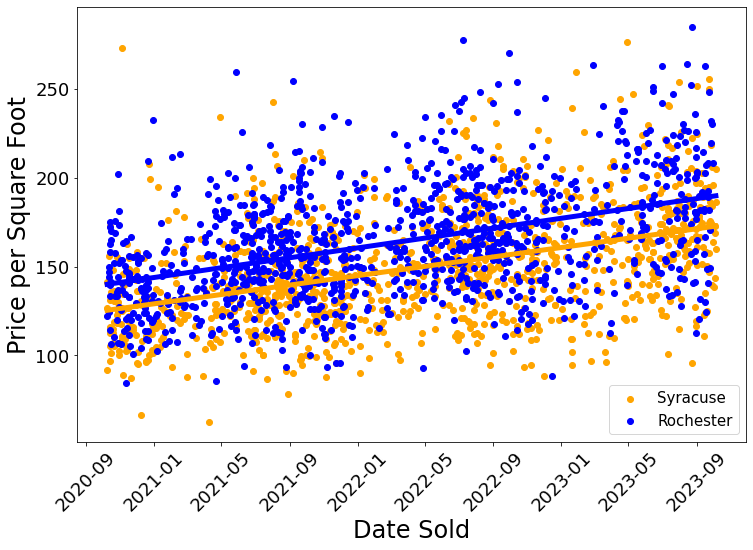

In [2825]:
syr_dates = [datetime.datetime.fromtimestamp(x) for x in syr_df.loc[:,"date_sold"]]
roc_dates = [datetime.datetime.fromtimestamp(x) for x in roc_df.loc[:,"date_sold"]]

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.scatter(syr_dates, syr_df['$ per sqft'], color='orange', label="Syracuse")
ax.scatter(roc_dates, roc_df['$ per sqft'], color='blue', label="Rochester")
ax.format_xdata = mdates.DateFormatter('%D:%M:%Y')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
ax.set_xlabel("Date Sold", fontsize=24)
ax.set_ylabel("Price per Square Foot", fontsize=24)

# Add the linear regression line
min_date = min(df["date_sold"])
max_date = max(df["date_sold"])
syr_reg_min_value = min_date * syr_reg.coef_ + syr_reg.intercept_
syr_reg_max_value = max_date * syr_reg.coef_ + syr_reg.intercept_
ax.plot([datetime.datetime.fromtimestamp(min_date), datetime.datetime.fromtimestamp(max_date)], [syr_reg_min_value, syr_reg_max_value], lw=5, color='orange')
roc_reg_min_value = min_date * roc_reg.coef_ + roc_reg.intercept_
roc_reg_max_value = max_date * roc_reg.coef_ + roc_reg.intercept_
ax.plot([datetime.datetime.fromtimestamp(min_date), datetime.datetime.fromtimestamp(max_date)], [roc_reg_min_value, roc_reg_max_value], lw=5, color='blue')

plt.show()

## Price per Square Foot Year vs Age of House
We need to figure out a way to take the year the house was built into account.

The slope is $-0.224844 per sqft per year old the house is
Correlation coefficient: 0.014098


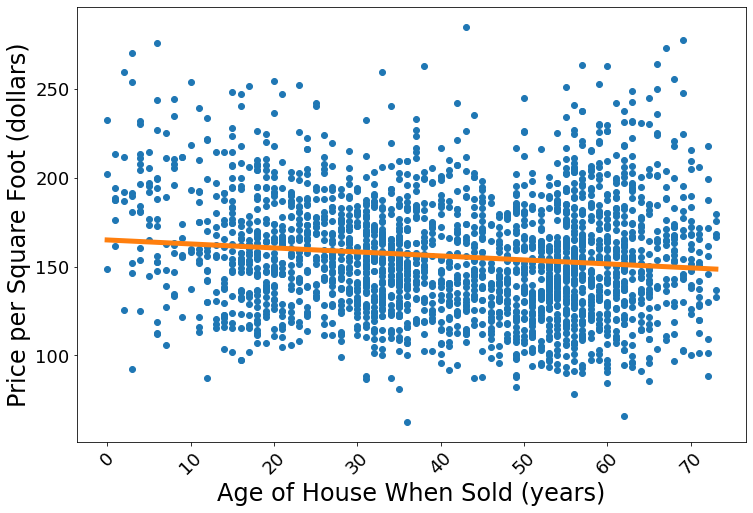

In [2868]:
# Perform the linear regression
X = np.array(df["age"]).reshape(-1, 1)
Y = df["$ per sqft"]
reg = LinearRegression().fit(X, Y)
print("The slope is $%f per sqft per year old the house is" % (float(reg.coef_[0])))
print("Correlation coefficient: %f" % (reg.score(X, Y)))

dates = [datetime.datetime.fromtimestamp(x) for x in df.loc[:,"date_sold"]]

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.plot(df["age"], df["$ per sqft"], 'o')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel("Age of House When Sold (years)", fontsize=24)
ax.set_ylabel("Price per Square Foot (dollars)", fontsize=24)

# Add the linear regression line
min_age = min(df["age"])
max_age = max(df["age"])
reg_min_value = min_age * reg.coef_ + reg.intercept_
reg_max_value = max_age * reg.coef_ + reg.intercept_
ax.plot([min_age, max_age], [reg_min_value, reg_max_value], lw=5)

plt.show()

The slope is -0.22, meaning for each year old the house is, it sells for 22 cents less per square foot. This means a 70 year old 2000 sqft house would sell for 26,400 dollars less than it would if it were 10 years old.

## Plotting price per sqft, age, and date sold together

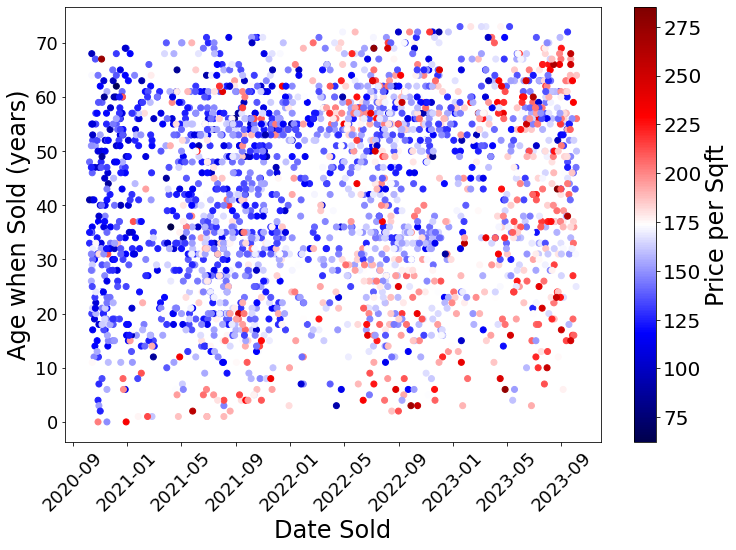

In [2916]:
dates = [datetime.datetime.fromtimestamp(x) for x in df.loc[:,"date_sold"]]
min_pps = min(df["$ per sqft"])
max_pps = max(df["$ per sqft"])
colors = [(x - min_pps) / (max_pps - min_pps) for x in df['$ per sqft']]

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.scatter(dates, df['age'], c=colors, cmap='seismic')
ax.format_xdata = mdates.DateFormatter('%D:%M:%Y')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel("Date Sold", fontsize=24)
ax.set_ylabel("Age when Sold (years)", fontsize=24)

jet = plt.get_cmap('jet')
cNorm  = matplotlib.colors.Normalize(vmin=min_pps, vmax=max_pps)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='seismic')
cbar = plt.colorbar(scalarMap, orientation='vertical')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel("Price per Sqft", fontsize=24)
plt.show()

## Geographic Plot

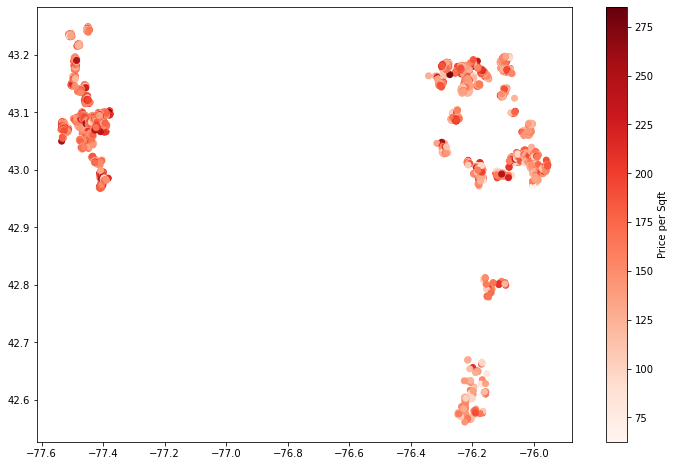

In [2903]:
min_pps = min(df["$ per sqft"])
max_pps = max(df["$ per sqft"])
colors = [(x - min_pps) / (max_pps - min_pps) for x in df['$ per sqft']]

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.scatter(df['lon'], df['lat'], c=colors, cmap='Reds')
jet = plt.get_cmap('jet')
cNorm  = matplotlib.colors.Normalize(vmin=min_pps, vmax=max_pps)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='Reds')
plt.colorbar(scalarMap, orientation='vertical', label='Price per Sqft')
plt.show()